## Data Loading

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dylanjcastillo/7k-books-with-metadata")

print("Path to dataset files:", path)

100%|██████████| 1.47M/1.47M [00:00<00:00, 41.5MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/dylanjcastillo/7k-books-with-metadata/versions/3


In [3]:
import pandas as pd
books = pd.read_csv(f"{path}/books.csv")

In [4]:
books.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0


## Data Understanding

In [5]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6810 entries, 0 to 6809
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   isbn13          6810 non-null   int64  
 1   isbn10          6810 non-null   object 
 2   title           6810 non-null   object 
 3   subtitle        2381 non-null   object 
 4   authors         6738 non-null   object 
 5   categories      6711 non-null   object 
 6   thumbnail       6481 non-null   object 
 7   description     6548 non-null   object 
 8   published_year  6804 non-null   float64
 9   average_rating  6767 non-null   float64
 10  num_pages       6767 non-null   float64
 11  ratings_count   6767 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 638.6+ KB


In [8]:
books.describe().T

,count,mean,std,min,25%,50%,75%,max
isbn13,6810.0,9.780677e+12,6.068911e+08,9.780002e+12,9.780330e+12,9.780553e+12,9.780810e+12,9.789042e+12
published_year,6804.0,1.998630e+03,1.048426e+01,1.853000e+03,1.996000e+03,2.002000e+03,2.005000e+03,2.019000e+03
average_rating,6767.0,3.933284e+00,3.313516e-01,0.000000e+00,3.770000e+00,3.960000e+00,4.130000e+00,5.000000e+00
num_pages,6767.0,3.481810e+02,2.423768e+02,0.000000e+00,2.080000e+02,3.040000e+02,4.200000e+02,3.342000e+03
ratings_count,6767.0,2.106910e+04,1.376207e+05,0.000000e+00,1.590000e+02,1.018000e+03,5.992500e+03,5.629932e+06


In [19]:
books.isna().sum().sort_values(ascending=False)

,0
subtitle,4429
thumbnail,329
description,262
categories,99
authors,72
average_rating,43
num_pages,43
ratings_count,43
published_year,6
isbn13,0


### Check if our missing values have any patterns

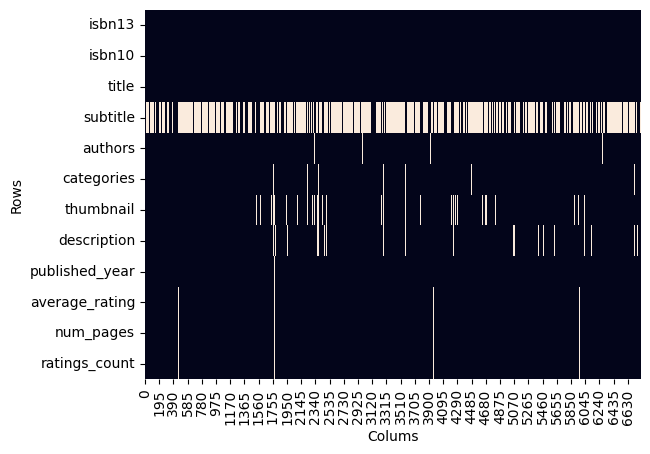

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = plt.axes()
sns.heatmap(books.isna().transpose(), cbar=False, ax=ax)
plt. xlabel("Colums")
plt.ylabel("Rows")
plt.show()

Subtitel it mostly missing. For Categories, thumbnail and description it looks random.For averate rating, number of pages and ratings_count, there is a pattern, in that an observation with one missing, has all of them missing.

## Inspecting the books where the Description is Missing
This is important because it is the core field we are going, and it is good to know if there is bias in the type of description missing.
We will use the year the book was published, the no of pages the book has, and avg rating the book, to look at if the books with missing description are more likely to be older or shorter

In [30]:
import numpy as np
books['missing_description'] = np.where(books['description'].isna(), 1, 0)
books['age_of_book'] = 2025 - books['published_year']

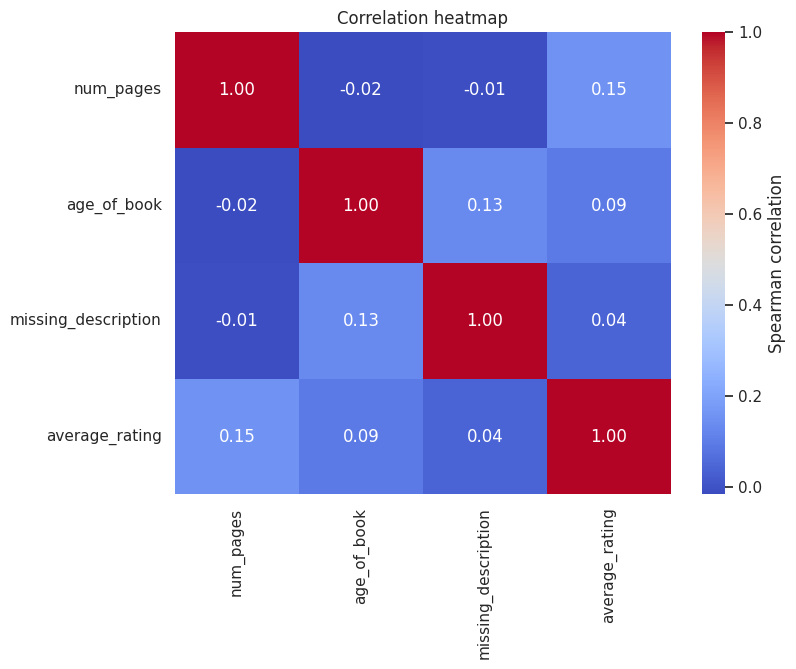

In [33]:

columns_of_interest = ["num_pages", "age_of_book", "missing_description", "average_rating"]

correlation_matrix = books[columns_of_interest].corr(method = "spearman")

sns.set_theme(style="white")
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm",
                      cbar_kws={"label": "Spearman correlation"})
heatmap.set_title("Correlation heatmap")
plt.show()

We are interested in missing description correlation with the other variables. We want to know Whether any of those variables has a high correlation with missing description.
The reason is, say no of pages was highly correlated with missing description, it would indicate that either longer books, or shorter books has a missing description. Which might result into out recommender being biased on the longer or shorter books (Applies with the other variables as well) .

From the graph however, there is no strong correlation between the variables. So we have confidence that, atleast interms of these dimensions, our book description are well represented.

## Handling the Missing Values

In [42]:
book_missing = books[~(books["description"].isna()) &
      ~(books["num_pages"].isna()) &
      ~(books["average_rating"].isna()) &
      ~(books["published_year"].isna())
]



In [43]:
book_missing

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,21.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,25.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0,0,43.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,32.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6803,9788173031014,8173031010,Journey to the East,NaN,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,0,23.0
6804,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,NaN,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,0,22.0
6805,9788185300535,8185300534,I Am that,Talks with Sri Nisargadatta Maharaj,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,0,26.0
6808,9789027712059,9027712050,The Berlin Phenomenology,NaN,Georg Wilhelm Friedrich Hegel,History,http://books.google.com/books/content?id=Vy7Sk...,Since the three volume edition ofHegel's Philo...,1981.0,0.00,210.0,0.0,0,44.0


In [44]:
book_missing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6507 entries, 0 to 6809
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   isbn13               6507 non-null   int64  
 1   isbn10               6507 non-null   object 
 2   title                6507 non-null   object 
 3   subtitle             2281 non-null   object 
 4   authors              6444 non-null   object 
 5   categories           6474 non-null   object 
 6   thumbnail            6293 non-null   object 
 7   description          6507 non-null   object 
 8   published_year       6507 non-null   float64
 9   average_rating       6507 non-null   float64
 10  num_pages            6507 non-null   float64
 11  ratings_count        6507 non-null   float64
 12  missing_description  6507 non-null   int64  
 13  age_of_book          6507 non-null   float64
dtypes: float64(5), int64(2), object(7)
memory usage: 762.5+ KB


## Handling the Category Field

In [45]:
book_missing["categories"].value_counts().reset_index().sort_values("count", ascending=False )

,categories,count
0,Fiction,2523
1,Juvenile Fiction,534
2,Biography & Autobiography,391
3,History,258
4,Literary Criticism,164
...,...,...
280,Butlers,1
279,Gardens,1
278,Assassins,1
277,Married people,1


## Checking the Description Column
Book description needs to meaningful, it needs to contain enough information , so that it can recommend


In [46]:
# We first check the legnth of description
# Short Description are not meaningful in this case
# We will count the no of words in the description column
book_missing["words_in_description"] = book_missing["description"].str.split().str.len()

<ipython-input-46-a71801c5a53d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_missing["words_in_description"] = book_missing["description"].str.split().str.len()


In [48]:
book_missing.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,words_in_description
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,21.0,199
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,25.0,205
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0,0,43.0,14
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,32.0,57
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,23.0,45


In [55]:
book_missing["words_in_description"].describe()

,words_in_description
count,6507.000000
mean,66.325803
std,66.120291
min,1.000000
25%,27.000000
50%,40.000000
75%,82.000000
max,920.000000


In [56]:
book_missing.loc[book_missing["words_in_description"].between(1, 4), "description"]


,description
6,Donation.
11,Fantasy-roman.
748,Includes bibliographical references.
770,Bound For Oregon (PB)
775,No Marketing Blurb
812,No Marketing Blurb
857,First published in 1813.
944,Edited by Maurice Hindle.
953,DEFOE/ROBINSON CRUSOE (BC)
954,Edited by John Carey.


In [57]:
book_missing.loc[book_missing["words_in_description"].between(5, 14), "description"]


,description
2,Volume Two of Stephen Donaldson's acclaimed se...
38,Koko is Peter Straub's foray into the psycholo...
70,A matter of life and death - and the Throne of...
77,Nonsense rhyming story. 4 yrs+
84,A study guide for the novel There's a Boy in t...
...,...
6715,The first comprehensive guide to addressing Na...
6726,Presents two complete novels from Henry James.
6757,Audio Book- unabriged on CD
6776,Raymond Chandler meets The Exorcist. Classic n...


In [58]:
book_missing.loc[book_missing["words_in_description"].between(25, 34), "description"]


,description
9,Kate Blackwell is an enigma and one of the mos...
14,"Available in the U.S. for the first time, this..."
20,"It is 1937, and Charles Ashworth, a Canon to t..."
21,Reissue of the author's most famous and well-l...
46,No one believes a little girl when she insists...
...,...
6760,"Joel, an English teacher, has never really lik..."
6766,Discusses the historical and intellectual back...
6775,Presents nearly one thousand recipes--from app...
6779,Edited by the creator and executive producer o...


In [59]:
book_missing_25_words = book_missing[book_missing["words_in_description"] >= 25]


In [61]:
book_missing_25_words.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,words_in_description
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,21.0,199
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,25.0,205
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,32.0,57
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,23.0,45
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,0,23.0,75


In [62]:
book_missing_25_words.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5197 entries, 0 to 6808
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   isbn13                5197 non-null   int64  
 1   isbn10                5197 non-null   object 
 2   title                 5197 non-null   object 
 3   subtitle              1817 non-null   object 
 4   authors               5165 non-null   object 
 5   categories            5167 non-null   object 
 6   thumbnail             5031 non-null   object 
 7   description           5197 non-null   object 
 8   published_year        5197 non-null   float64
 9   average_rating        5197 non-null   float64
 10  num_pages             5197 non-null   float64
 11  ratings_count         5197 non-null   float64
 12  missing_description   5197 non-null   int64  
 13  age_of_book           5197 non-null   float64
 14  words_in_description  5197 non-null   int64  
dtypes: float64(5), int64(3), o

## Handling Subtitle Column
It is a common convetion to have the title and subtitle together. So in this case, we are going to combine the title and subtitle, and when the subtitle is missing, we are going to have the title only.

In [65]:
book_missing_25_words["title_and_subtitle"] = (
    np.where(book_missing_25_words["subtitle"].isna(), book_missing_25_words["title"],
             book_missing_25_words[["title", "subtitle"]].astype(str).agg(": ".join, axis=1))
)

<ipython-input-65-ca11fb5eaf40>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_missing_25_words["title_and_subtitle"] = (


In [66]:
book_missing_25_words.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,words_in_description,title_and_subtitle
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,21.0,199,Gilead
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,25.0,205,Spider's Web: A Novel
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,32.0,57,Rage of angels
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,23.0,45,The Four Loves
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,0,23.0,75,The Problem of Pain


In [67]:
book_missing_25_words.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5197 entries, 0 to 6808
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   isbn13                5197 non-null   int64  
 1   isbn10                5197 non-null   object 
 2   title                 5197 non-null   object 
 3   subtitle              1817 non-null   object 
 4   authors               5165 non-null   object 
 5   categories            5167 non-null   object 
 6   thumbnail             5031 non-null   object 
 7   description           5197 non-null   object 
 8   published_year        5197 non-null   float64
 9   average_rating        5197 non-null   float64
 10  num_pages             5197 non-null   float64
 11  ratings_count         5197 non-null   float64
 12  missing_description   5197 non-null   int64  
 13  age_of_book           5197 non-null   float64
 14  words_in_description  5197 non-null   int64  
 15  title_and_subtitle    5197

We want a new description column, which has new description togther with a unique identifier.

In [68]:
book_missing_25_words["tagged_description"] = book_missing_25_words[["isbn13", "description"]].astype(str).agg(" ".join, axis=1)


<ipython-input-68-f634ed973c47>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_missing_25_words["tagged_description"] = book_missing_25_words[["isbn13", "description"]].astype(str).agg(" ".join, axis=1)


In [69]:
book_missing_25_words.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,words_in_description,title_and_subtitle,tagged_description
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,21.0,199,Gilead,9780002005883 A NOVEL THAT READERS and critics...
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,25.0,205,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,32.0,57,Rage of angels,"9780006178736 A memorable, mesmerizing heroine..."
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,23.0,45,The Four Loves,9780006280897 Lewis' work on the nature of lov...
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,0,23.0,75,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le..."


In [70]:
(
    book_missing_25_words
    .drop(["subtitle", "missing_description", "age_of_book", "words_in_description"], axis=1)
    .to_csv("data_cleaned.csv", index = False)
)